In [1]:
%load_ext autoreload
%autoreload 2
import os
#change current working directory to the parent directory
changed = False
if not changed:
    os.chdir("..")
    changed = True
    print("Changed working directory to parent directory")
import numpy as np
import sr_mcmc as srmc
import argparse
import config_lib as cl
import deathTimesDataSet as dtds
import ast
import readResults as rr
import corner
import matplotlib.pyplot as plt
import matplotlib
import SRmodellib as sr
import SRmodellib_lifelines as srl
import emcee

Changed working directory to parent directory


In [2]:
config_path = "configs/configs_human_f"
temp_results_path = "temp_results/Human_F"  
results_path = "results_csvs/Human_F_years"
apply_thresh = True
scale = 365


In [3]:
#get the name of current folder:
current_folder = os.path.basename(os.getcwd())

In [4]:
config = cl.read_configs(config_path)
nsteps = int(config.get('DEFAULT', 'nsteps'))
npeople = int(config.get('DEFAULT', 'npeople'))
t_end = int(config.get('DEFAULT', 't_end'))
nwalkers = int(config.get('DEFAULT', 'nwalkers'))
nsteps = int(config.get('DEFAULT', 'nsteps'))
num_mcmc_steps = int(config.get('DEFAULT', 'n_mcmc_steps'))
metric = config.get('DEFAULT', 'metric')
time_range = ast.literal_eval(config.get('DEFAULT', 'time_range'))
time_step_multiplier = int(config.get('DEFAULT', 'time_step_multiplier'))
data_file = config.get('DEFAULT', 'data_file')
seed_file = config.get('DEFAULT', 'seed_file')
variations = ast.literal_eval(config.get('DEFAULT', 'variations'))
prior = int(config.get('DEFAULT', 'prior'))
transform = bool(config.get('DEFAULT', 'transform'))
index = int(config.get('DEFAULT', 'index'))
submission_folder = config.get(f'SUBMISSION_{index-1}', 'submission_folder')
external_hazard = ast.literal_eval(config.get('DEFAULT', 'external_hazard'))

#all paths are in absolute paths (start with ~/). change all paths to be relative to the current folder 
# (remove everything before the current folder name)
data_file = data_file.split(current_folder)[-1]
seed_file = seed_file.split(current_folder)[-1]
submission_folder = submission_folder.split(current_folder)[-1]
#remove the first / from the paths
data_file = data_file[1:]
seed_file = seed_file[1:]
submission_folder = submission_folder[1:]



h5_folder = f"{submission_folder}/h5_files"

In [5]:
ds = dtds.dsFromFile(data_file)
ds.external_hazard = external_hazard
seed_res = rr.readResultsFile(seed_file)
res_df = seed_res[1]
seed = rr.getTheta(res_df)
if transform:
    seed_trans = srmc.transform(seed)

Reading Human_F


In [6]:
samples_trans0, lnprobs0 = srmc.loadSamplesFromDir(h5_folder, best=False, thin =5, discard=200)


thresh: -99587.54559266989


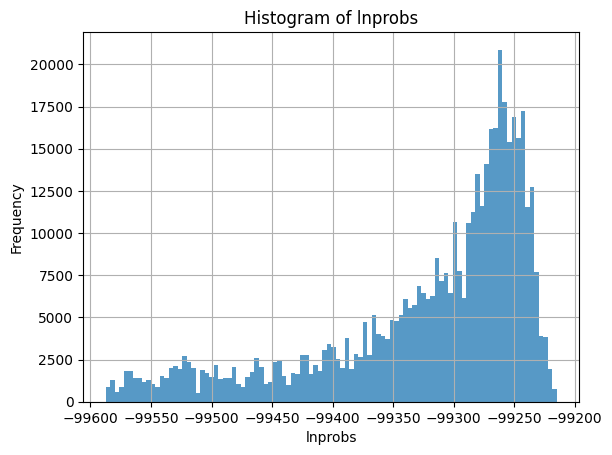

In [7]:
#plot a histogram of lnprobs2
#thresh is the threshold for lnprobs. lnprobs below thresh are not plotted
#thresh is the 95th percentile of lnprobs
thresh = np.percentile(lnprobs0, 88)
print(f"thresh: {thresh}")
# thresh =-np.inf

plt.hist(lnprobs0[lnprobs0>thresh], bins=100, alpha=0.75)
plt.xlabel('lnprobs')
plt.ylabel('Frequency')
plt.title('Histogram of lnprobs')
plt.grid(True)
plt.show()

In [8]:
if apply_thresh:
    samples_trans = samples_trans0[lnprobs0>thresh]
    lnprobs = lnprobs0[lnprobs0>thresh]

In [9]:
sorted_samples_trans = samples_trans[np.argsort(lnprobs)]
sorted_lnprobs = np.sort(lnprobs)
#get the median values of all the parameters
p1,p2,p3,p4 = srmc.get_params_from_thetas(sorted_samples_trans)
medians_trans = [np.median(p1),np.median(p2),np.median(p3),np.median(p4)]
means_trans = [np.mean(p1),np.mean(p2),np.mean(p3),np.mean(p4)]
stds_trans = [np.std(p1),np.std(p2),np.std(p3),np.std(p4)]
#calc the median deviations of the params
from scipy.stats import median_abs_deviation
medev_trans = [median_abs_deviation(p1),median_abs_deviation(p2),median_abs_deviation(p3),median_abs_deviation(p4)]

In [10]:
samples =np.array([srmc.inv_transform(sample) for sample in samples_trans])

In [11]:
sorted_samples = samples[np.argsort(lnprobs)]
sorted_lnprobs = np.sort(lnprobs)
#get the median values of all the parameters
etas,betas,epsilons,xcs = srmc.get_params_from_thetas(sorted_samples)
medians = [np.median(etas),np.median(betas),np.median(epsilons),np.median(xcs)]
means = [np.mean(etas),np.mean(betas),np.mean(epsilons),np.mean(xcs)]
stds = [np.std(etas),np.std(betas),np.std(epsilons),np.std(xcs)]
#calc the median deviations of the params
from scipy.stats import median_abs_deviation
medev = [median_abs_deviation(etas),median_abs_deviation(betas),median_abs_deviation(epsilons),median_abs_deviation(xcs)]



(16,)


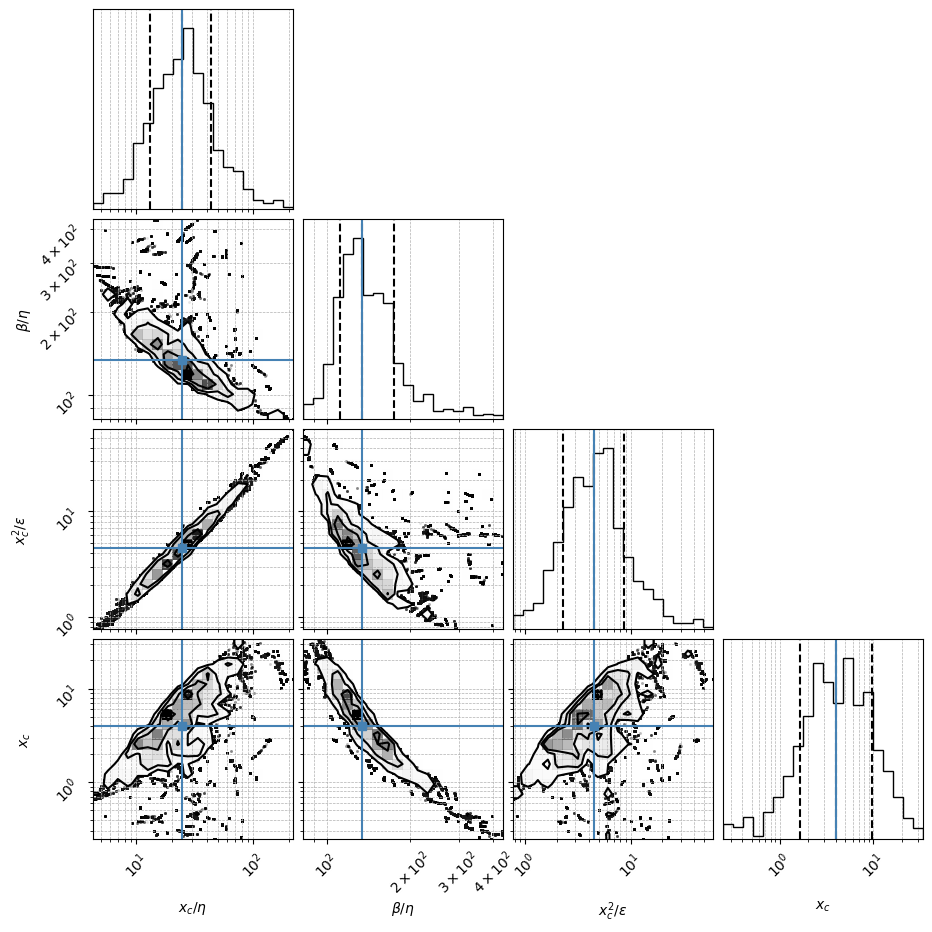

In [16]:
fig = corner.corner(samples_trans, labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"], axes_scale='log',quantiles=[0.16, 0.5, 0.84], truths=medians_trans)
axes=fig.get_axes()
print(np.shape(axes))
for ax in axes:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

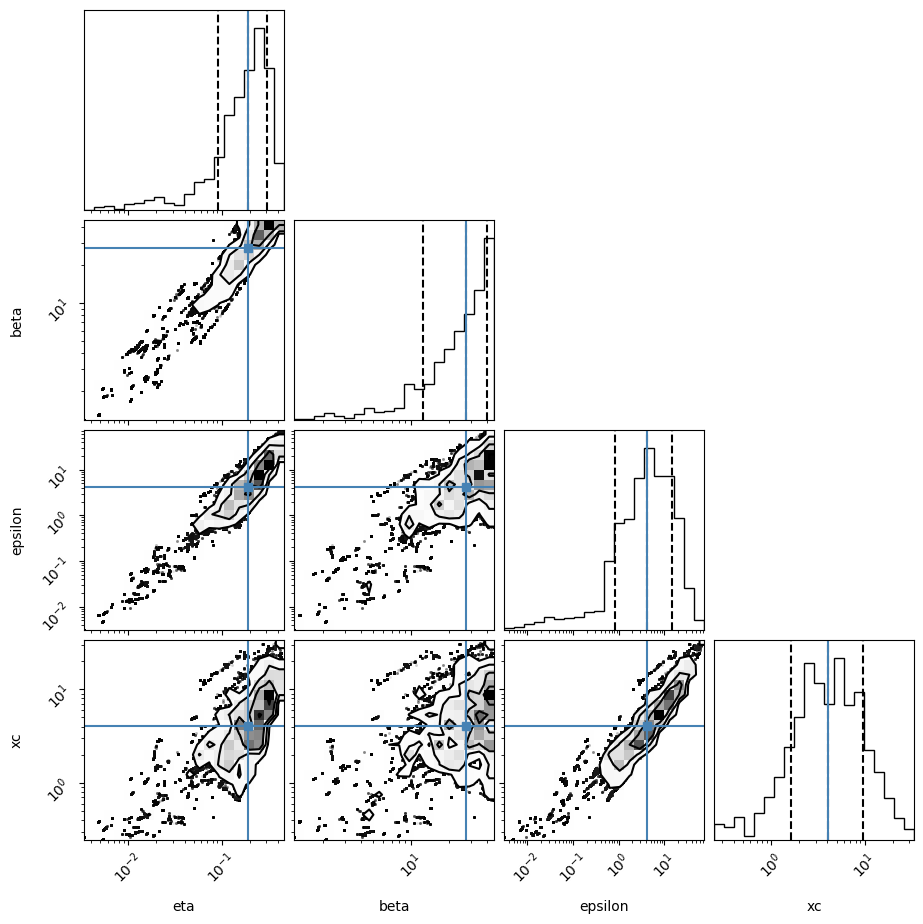

In [17]:
fig = corner.corner(samples, labels=['eta','beta','epsilon','xc'],axes_scale='log',quantiles=[0.16, 0.5, 0.84], truths=medians)

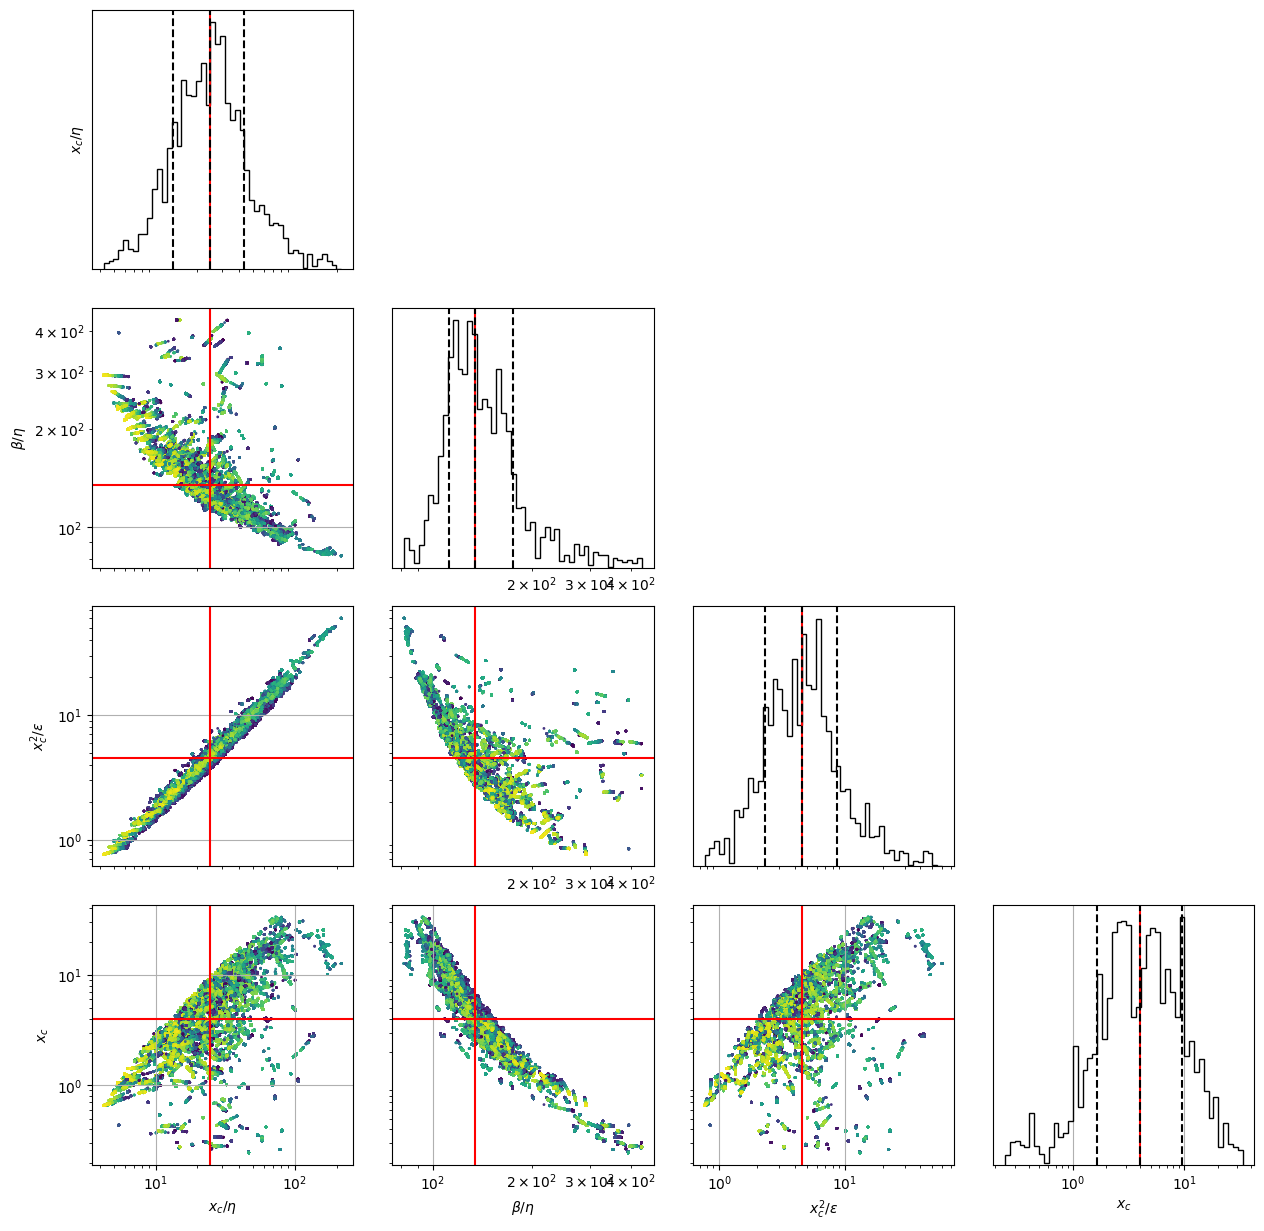

In [18]:
fig,ax=srmc.custom_corner(samples_trans,lnprobs, truths= medians_trans, labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"])

In [19]:

fact=1
import boltsman_stats as bs
dfb = bs.get_stats(samples, lnprobs,ds, file_path=temp_results_path,percent=False)

                             Eta   Beta  Epsilon    Xc  Beta/Eta  Beta*Xc/Eps  Fx=Beta^2/(Eta*Xc)  Dx=Beta*Eps/(Eta*Xc^2)  Xc^2/Eps  Beta*Kappa/Eps  Fk=Beta^2/(Eta*Kappa)  Dk=Beta*Eps/(Eta*Kappa^2)  s=(Xc^1.5*Eta^0.5)/Eps  Slope=Eta*Xc/Eps  Xc/Eps  Fk/Dk    Fk^2/Dk  t_eta  Median Lifetime
Best fit                   0.220  43.66     1.75  1.42    200.83        35.45             6167.65                  174.00      1.15           12.47               17537.11                    1406.80                    0.45             0.180    0.81  12.47  218617.45   2.56             77.0
Median                     0.190  27.03     4.11  4.01    134.46        24.83              786.42                   31.09      4.55            3.07                7299.78                    2244.39                    0.91             0.180    0.93   3.07   19768.97   4.97             77.0
Mean                       0.200  26.44     7.55  5.64    147.99        28.10             1485.34                   45.62      6.1

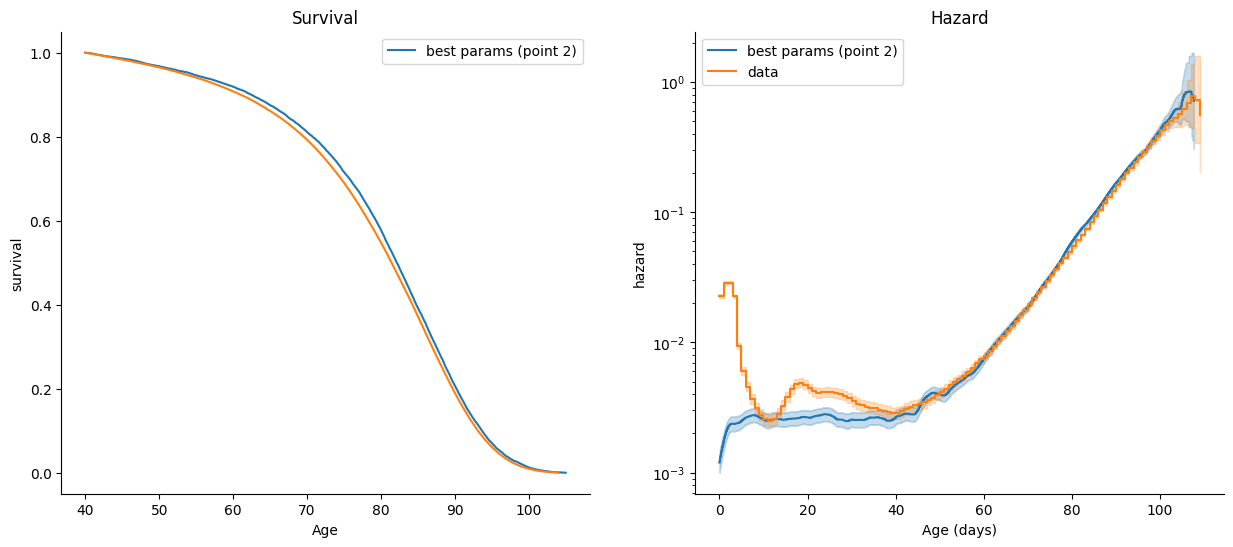

In [ ]:
print(sorted_samples[-1])

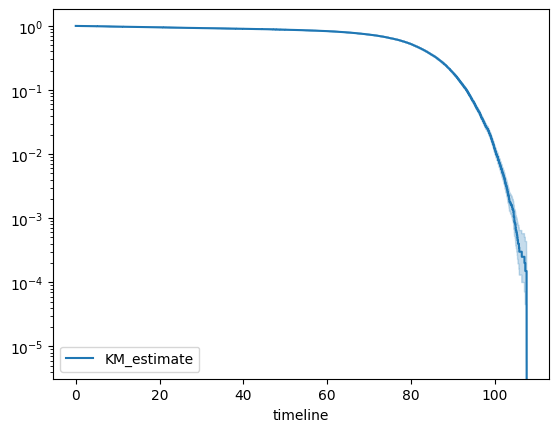

In [32]:
print(ds.external_hazard)

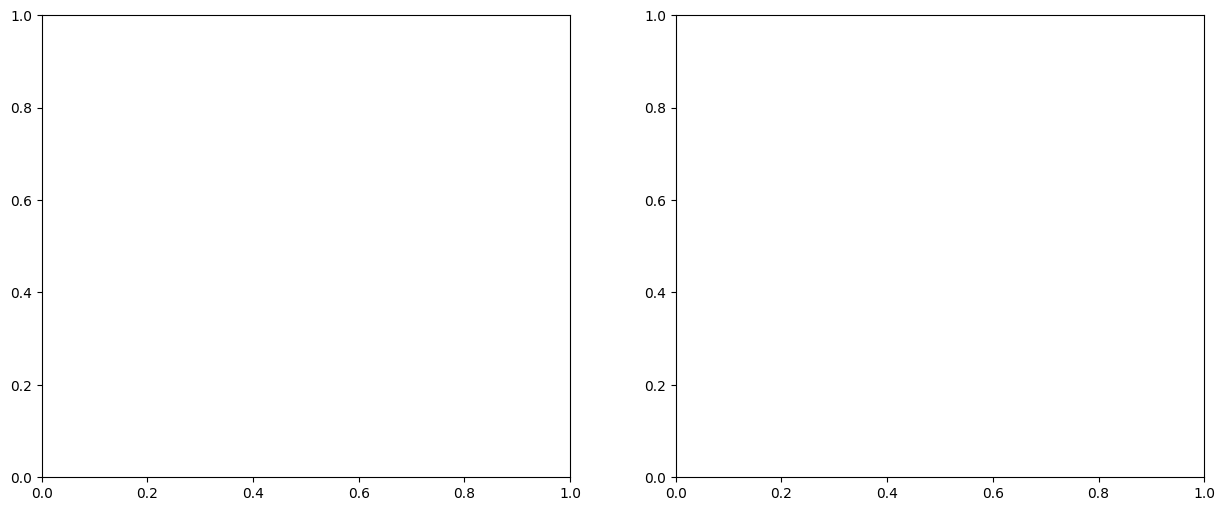

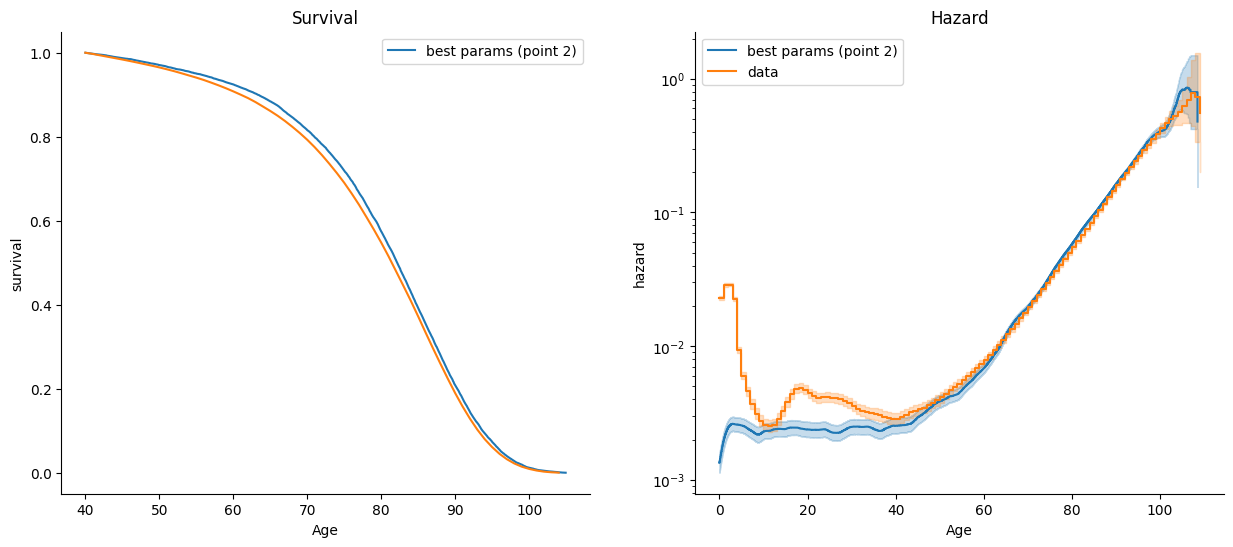

In [ ]:

best_theta = sorted_samples[-1]
fig, axs = plt.subplots(1, 2, figsize=(15, 6))


best_sim = srmc.getSr(best_theta, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard, parallel=True)


# Plot survival on ax[0]
ax0 = best_sim.plotSurvival(ax=axs[0],time_range=time_range, label='best params (point 2)', title='Survival', xlabel='time [years]', ylabel='survival')
ds.plotSurvival(ax=ax0, time_range=time_range,label='data')

# Plot hazard on ax[1]
ax1 = best_sim.plotHazard(ax=axs[1], title='Hazard', xlabel='time [years]', ylabel='hazard', label='best params (point 2)')
ds.plotHazard(ax=ax1, label='data')
ax1.set_yscale('log')
# ax0.set_yscale('log')

Averaging log-probabilities: 100%|██████████| 4309/4309 [00:00<00:00, 404558.71it/s]


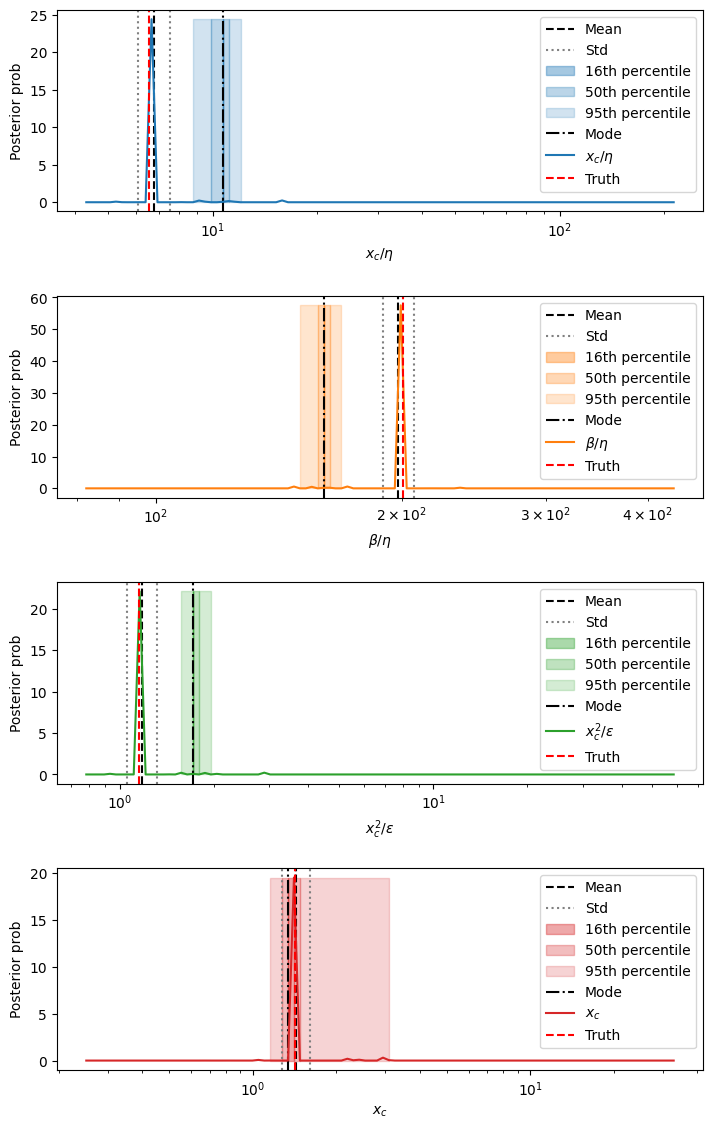

In [38]:
ax = best_sim.plotSurvival()
ax.set_yscale('log')

Creating corner plot:   0%|          | 0/4 [00:00<?, ?it/s]/Volumes/alon/navehr/baysian01/samples_utils.py:618: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(X, Y, Z, **kwargs)
Creating corner plot: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


array([[<Axes: xlabel='$x_c/\\eta$', ylabel='Posterior prob'>, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$x_c/\\eta$', ylabel='$\\beta/\\eta$'>,
        <Axes: xlabel='$\\beta/\\eta$', ylabel='Posterior prob'>,
        <Axes: >, <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$x_c/\\eta$', ylabel='$x_c^2/\\epsilon$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$\\beta/\\eta$', ylabel='$x_c^2/\\epsilon$'>,
        <Axes: xlabel='$x_c^2/\\epsilon$', ylabel='Posterior prob'>,
        <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$x_c/\\eta$', ylabel='$x_c$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$\\beta/\\eta$', ylabel='$x_c$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$x_c^2/\\epsilon$', ylabel='$x_c$'>,
        <Axes: xlabel='$x_c$', ylabel='Posterior prob'>]], dtype=object)

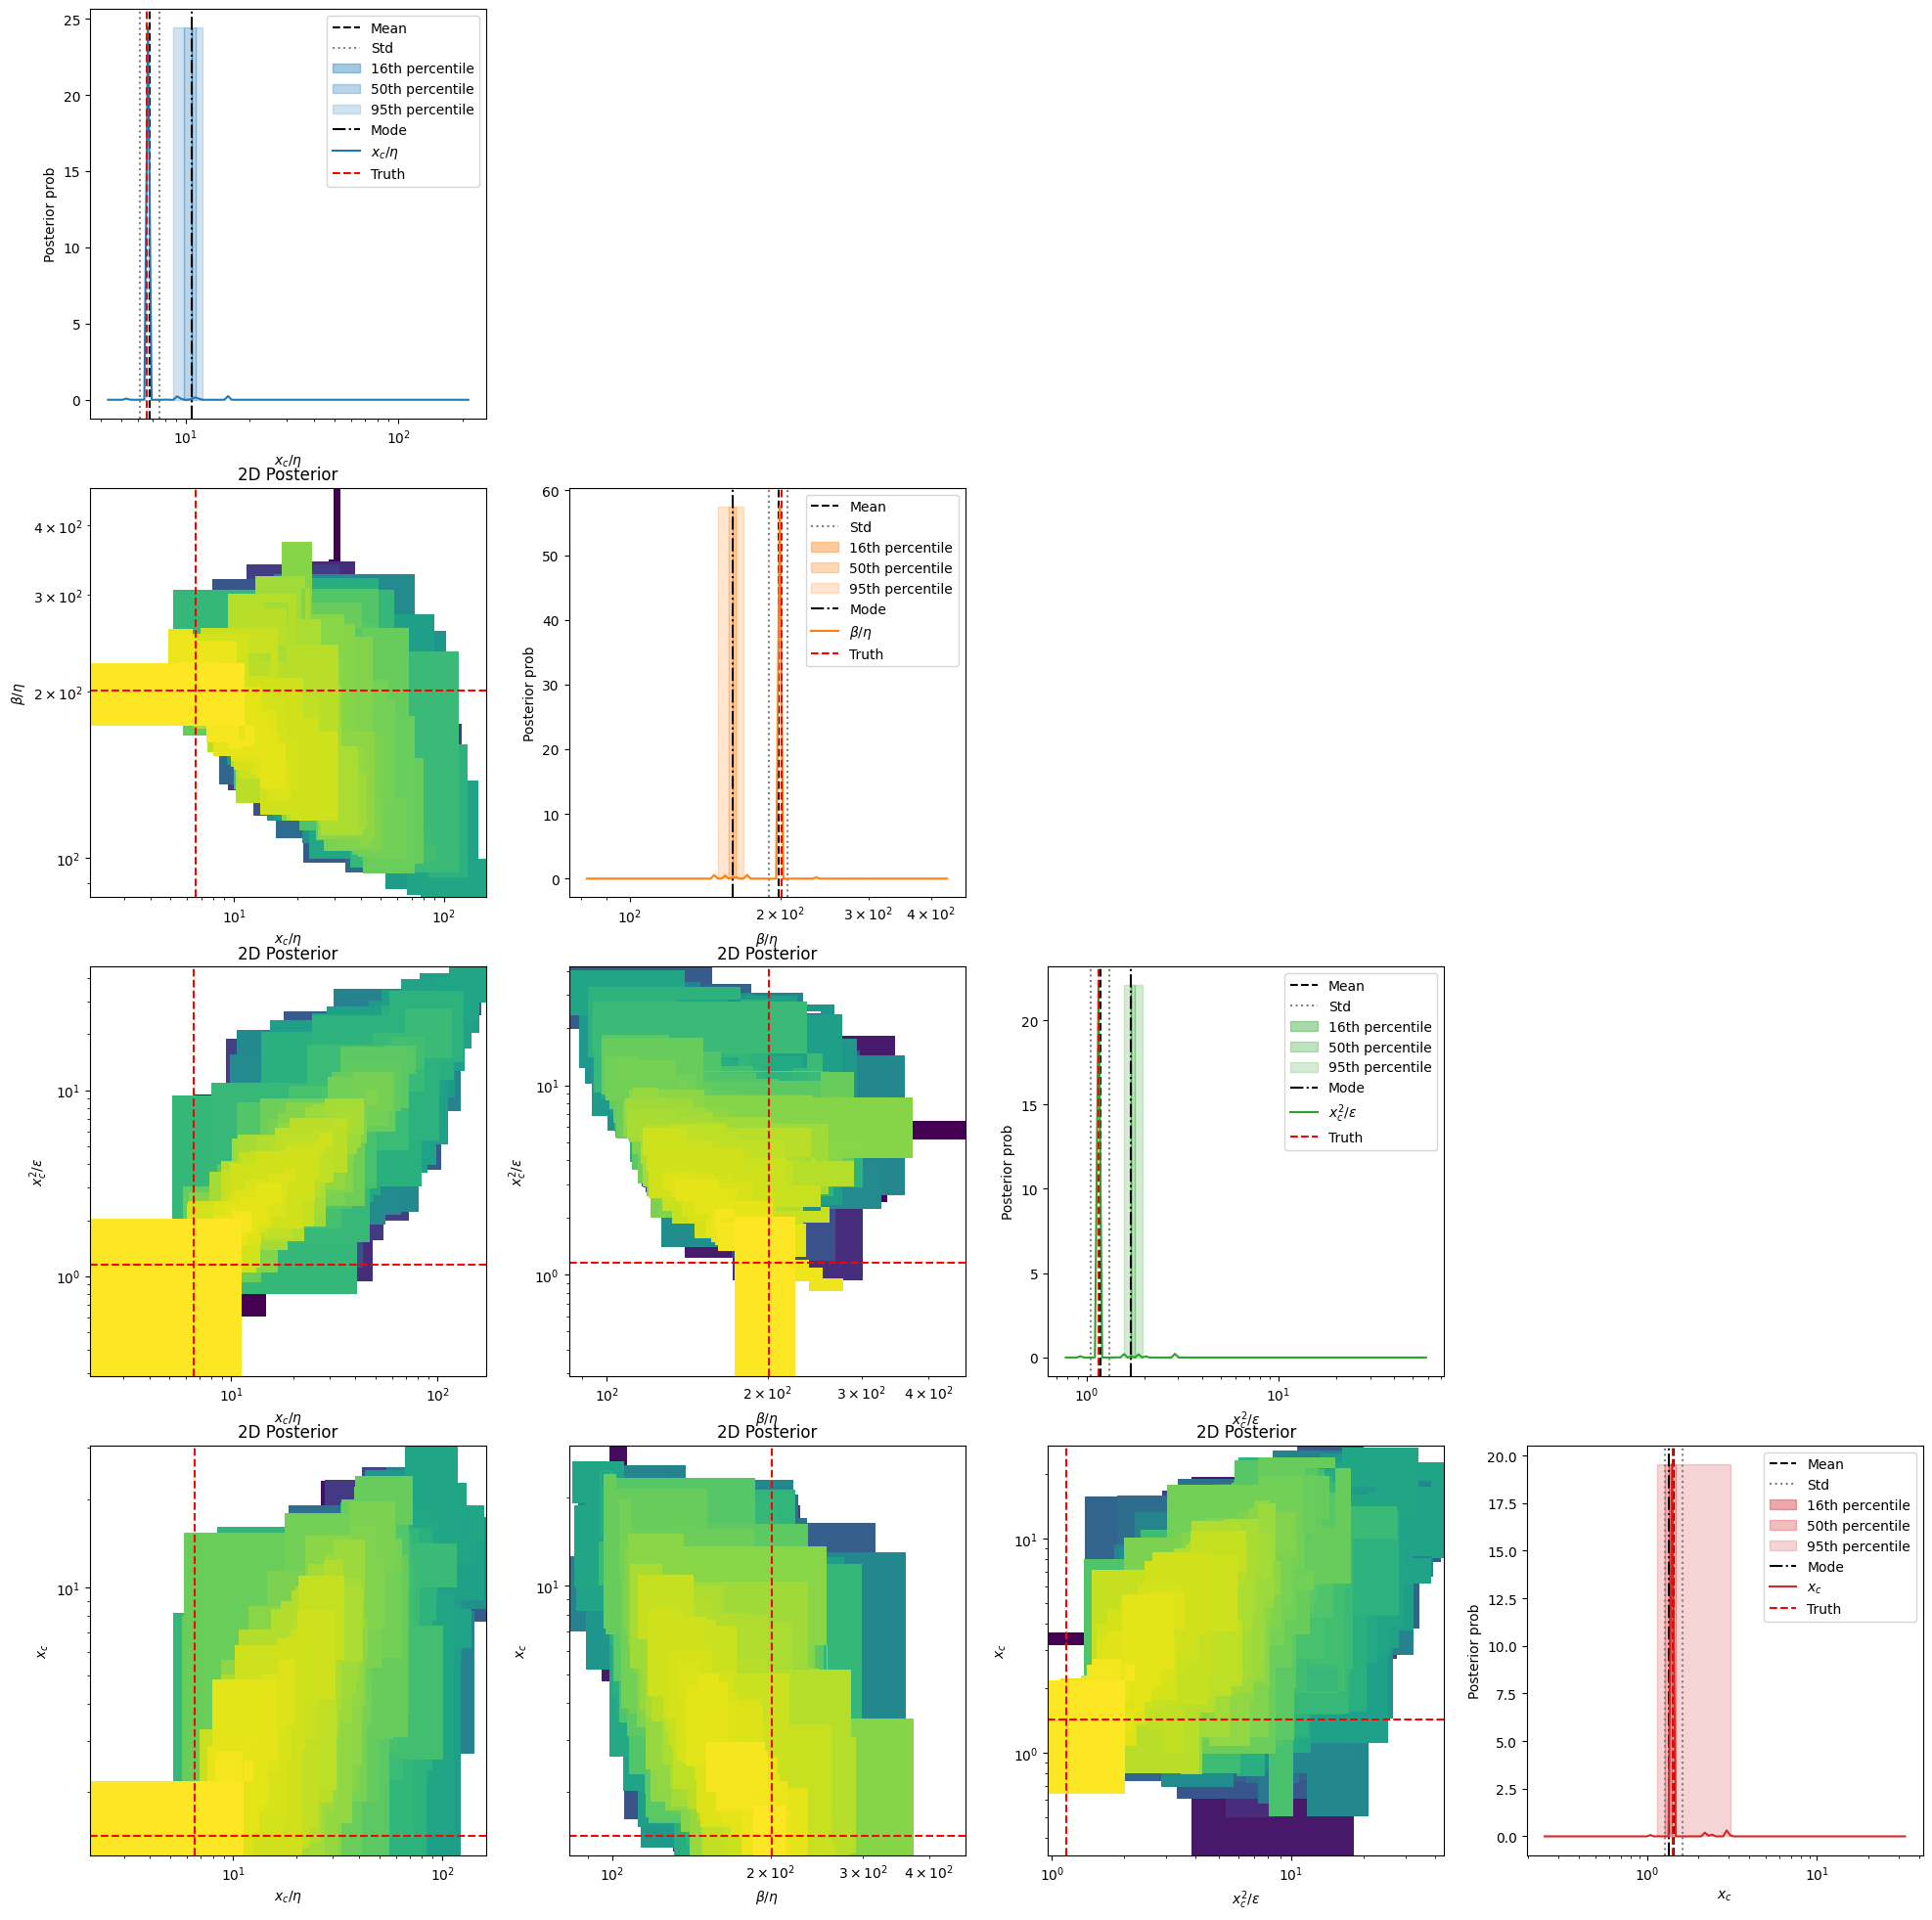

In [39]:
#add plots of the death time distributions of the best fit and data:
fig,ax = plt.subplots(1,1, figsize=(10,6))
ds.plotDeathTimesDistribution(ax=ax,use_kde=True ,label='data', color='r',alpha=0.9)
best_sim.plotDeathTimesDistribution(ax=ax,use_kde=True, label='best fit', color='b',alpha=0.9)
ax.legend()


Averaging log-probabilities: 100%|██████████| 4309/4309 [00:00<00:00, 272290.11it/s]


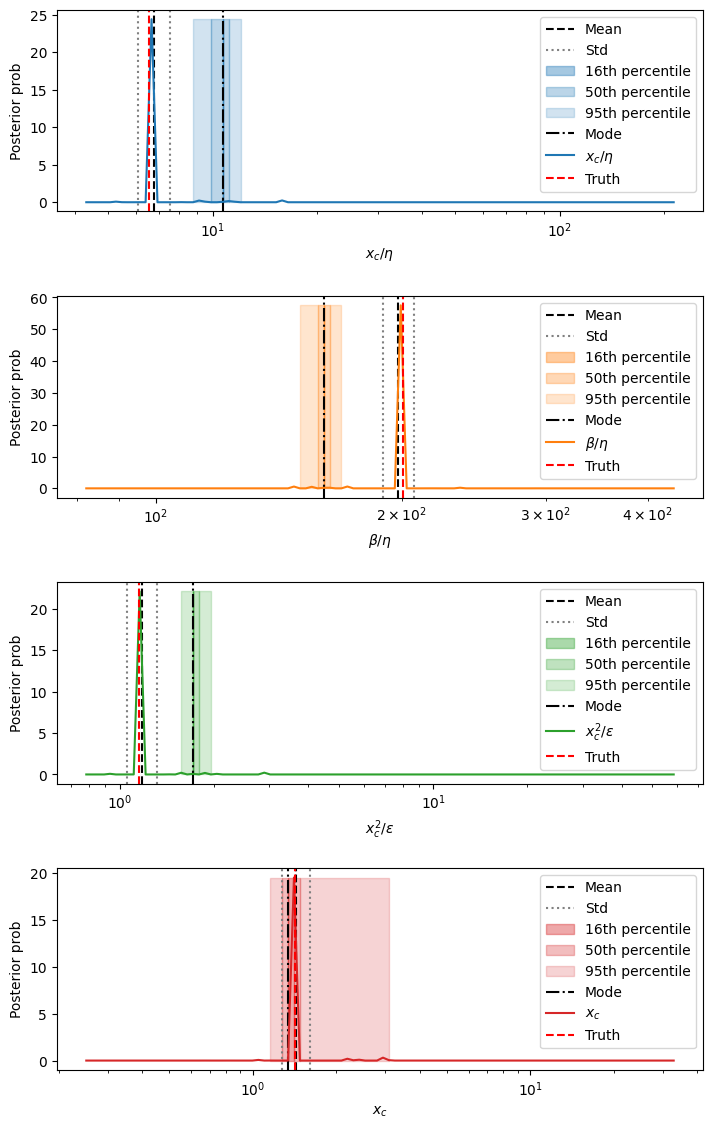

In [13]:
import samples_utils as su

post = su.Posterior(samples_trans, lnprobs, 100, log=True)
post.plot_1d_posteriors(labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"], truths=sorted_samples_trans[-1],scale='log',show_ln_prob=False)

In [41]:
post.corner_plot(labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"], truths=sorted_samples_trans[-1],scale='log',show_ln_prob=False,norm='log',plot_type="pcolormesh")

,mean,std,mode,percentile_16,percentile_50,percentile_95,max_likelihood
xc/eta,6.771,"[0.759, 0.683]",6.656,"[6.656, 6.656]","[4.314, 9.122]","[4.314, 15.838]",6.539
beta/eta,198.04,"[8.862, 8.482]",199.425,"[199.425, 199.425]","[171.544, 202.791]","[147.561, 202.791]",200.831
xc^2/epsilon,1.178,"[0.136, 0.122]",1.158,"[1.158, 1.158]","[1.061, 1.571]","[1.061, 2.893]",1.154
xc,1.435,"[0.176, 0.157]",1.407,"[1.407, 1.407]","[1.047, 2.192]","[1.047, 2.946]",1.422
eta,0.231,"[0.0464, 0.0387]",0.217,"[0.217, 0.217]","[0.187, 0.217]","[0.153, 0.292]",0.217
beta,40.777,"[5.037, 4.483]",44.802,"[44.802, 44.802]","[43.194, 44.802]","[34.69, 44.802]",43.661
epsilon,2.69,"[2.283, 1.235]",3.087,"[3.087, 3.087]","[2.79, 5.115]","[0.554, 14.045]",1.751
sqrt(xc/eta),3.078,"[0.724, 0.586]",2.58,"[2.58, 2.58]","[2.53, 2.58]","[2.077, 3.98]",2.557
s= eta^0.5*xc^1.5/epsilon,0.548,"[0.148, 0.117]",0.448,"[0.448, 0.448]","[0.448, 0.448]","[0.426, 0.733]",0.451
beta*xc/epsilon,32.023,"[4.647, 4.058]",35.539,"[35.539, 35.539]","[33.573, 38.34]","[27.25, 41.362]",35.446


In [14]:
path_days = f"{results_path.split('.csv')[0]}_days.csv" if results_path is not None else None
df=post.create_posterior_df(filepath=results_path, ds = [best_sim,ds], ds_labels=['best fit','data'])
df_days=post.create_posterior_df(filepath=path_days, ds = [best_sim,ds], ds_labels=['best fit','data'],rescale=scale)

Averaging log-probabilities: 100%|██████████| 4149/4149 [00:00<00:00, 244042.29it/s]


Rescaling the samples TIME by 365


Averaging log-probabilities: 100%|██████████| 4158/4158 [00:00<00:00, 304638.00it/s]


In [15]:
df

,mean,std,mode,percentile_16,percentile_50,percentile_95,max_likelihood
xc/eta,6.771,"[0.759, 0.683]",10.68,"[10.68, 10.68]","[9.87, 11.109]","[8.77, 12.02]",6.539
beta/eta,198.04,"[8.862, 8.482]",160.438,"[160.438, 160.438]","[157.775, 163.145]","[150.051, 168.697]",200.831
xc^2/epsilon,1.178,"[0.136, 0.122]",1.714,"[1.714, 1.714]","[1.714, 1.79]","[1.571, 1.953]",1.154
xc,1.435,"[0.176, 0.157]",1.34,"[1.34, 1.407]","[1.275, 1.478]","[1.156, 3.094]",1.422
eta,0.231,"[0.0464, 0.0387]",0.206,"[0.206, 0.206]","[0.206, 0.228]","[0.178, 0.252]",0.217
beta,40.777,"[5.037, 4.483]",44.802,"[44.802, 44.802]","[43.194, 44.802]","[38.709, 44.802]",43.661
epsilon,2.69,"[2.283, 1.235]",1.376,"[1.376, 1.376]","[1.244, 1.684]","[1.124, 4.179]",1.751
sqrt(xc/eta),3.078,"[0.724, 0.586]",3.08,"[3.08, 3.142]","[3.08, 3.268]","[2.58, 3.678]",2.557
s= eta^0.5*xc^1.5/epsilon,0.548,"[0.148, 0.117]",0.559,"[0.559, 0.559]","[0.545, 0.559]","[0.532, 0.587]",0.451
beta*xc/epsilon,32.023,"[4.647, 4.058]",27.772,"[27.772, 28.304]","[27.25, 28.846]","[25.743, 38.34]",35.446


Averaging log-probabilities: 100%|██████████| 3815/3815 [00:00<00:00, 418727.95it/s]


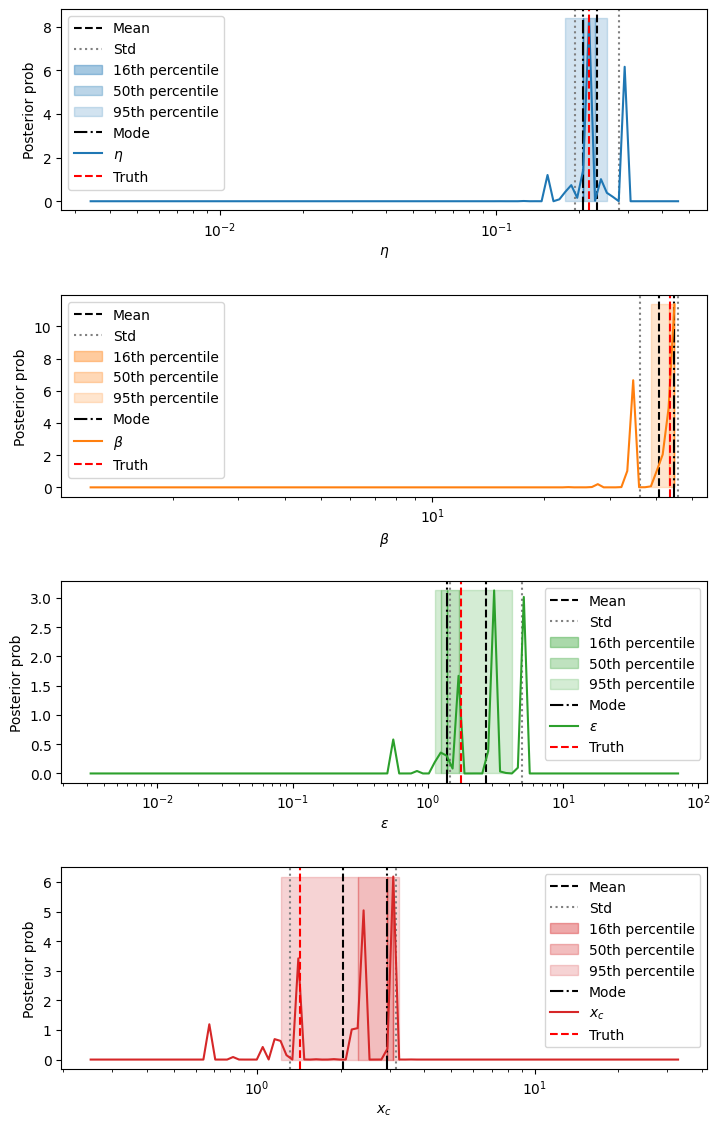

In [44]:
#get the theta of the modes of the posterior (from the df) location of indexes eta, beta, epsilon, xc and columen 'mode'
theta_mode =  df.loc[['eta','beta','epsilon','xc'],'mode'].values
print(f"theta_mode: {theta_mode}")
theta_mode_trans = df.loc[['xc/eta','beta/eta','xc^2/epsilon','xc'],'mode'].values
print(f"theta_mode_trans: {theta_mode_trans}")
sim_mode = srmc.getSr(theta_mode, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard,parallel=True)
sim_mode_trans = srmc.getSr(srmc.inv_transform(theta_mode_trans), nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard,parallel=True)


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot survival on ax[0]
ax0 = best_sim.plotSurvival(ax=axs[0],time_range=time_range, label='best params', title='Survival', xlabel='time [years]', ylabel='survival')
sim_mode.plotSurvival(ax=ax0,time_range=time_range, label='mode')
sim_mode_trans.plotSurvival(ax=ax0,time_range=time_range, label='mode trans')
ds.plotSurvival(ax=ax0,time_range=time_range, label='data')
ax0.legend()

# Plot hazard on ax[1]
ax1 = best_sim.plotHazard(ax=axs[1], title='Hazard', xlabel='time [years]', ylabel='hazard', label='best params')
sim_mode.plotHazard(ax=ax1, label='mode')
sim_mode_trans.plotHazard(ax=ax1, label='mode trans')
ds.plotHazard(ax=ax1, label='data')
ax1.set_yscale('log')

In [ ]:
post_regular_params = su.Posterior(samples, lnprobs, 100, log=True)
post_regular_params.plot_1d_posteriors(labels=["$\\eta$","$\\beta$","$\\epsilon$","$x_c$"], truths=sorted_samples[-1],scale='log')